# IF5281 Deep Learning - Tugas UAS Semester II 2023/2024
## Nama : Nabila Hannania
## NIM : 23523018

Eksperimen 7
- Model : GAN
- Jenis masking: Regular hole (box) mask pada lokasi acak pada gambar
- Batch size: 800

Referensi: https://github.com/AdeelH/gan-image-inpainting/tree/main

# Check GPU

In [1]:
!nvidia-smi

Fri Jun  7 22:24:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0              32W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils import data
from torch.utils.data import DataLoader, Subset
import cv2

# Data Preparation

In [3]:
# Define image transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # FLips the image w.r.t horizontal axis
    transforms.ToTensor()
])

# Download & read data
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Define the split ratio for validation set
validation_ratio = 0.2
num_train = len(train_data)
num_val = int(num_train * validation_ratio)
train_indices = list(range(num_train))
val_indices = train_indices[:num_val]
train_indices = train_indices[num_val:]

# Create subsets for training and validation
train = Subset(train_data, train_indices)
val = Subset(train_data, val_indices)

## Visualize Data

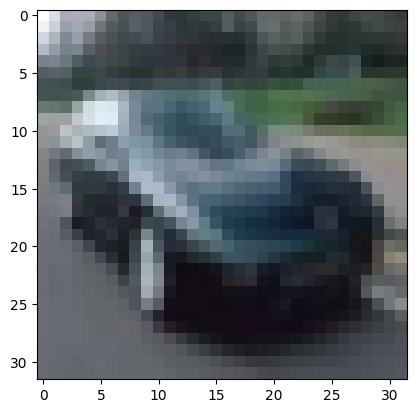

In [5]:
def imshow(tensor):
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    plt.imshow(tensor.cpu()[:3].permute(1, 2, 0))

imshow(train[1000][0])

In [6]:
def create_hole_mask(im_h, im_w, hole_h, hole_w):
    i = int((im_h - hole_h + 1) * np.random.random())
    j = int((im_w - hole_w + 1) * np.random.random())
    mask = torch.zeros((1, im_h, im_w))
    mask[0, i : i + hole_h, j : j + hole_w] = 1
    return mask, (i, i + hole_h, j, j + hole_w)

def create_hole_masks(N, im_h, im_w, hole_h, hole_w, same_size=True):
    if same_size:
        masks = [create_hole_mask(im_h, im_w, hole_h, hole_w) for _ in range(N)]
    else:
        h_min, h_max = hole_h
        w_min, w_max = hole_w
        hs, ws = np.random.randint(h_min, h_max, N), np.random.randint(w_min, w_max, N)
        masks = [create_hole_mask(im_h, im_w, h, w) for h, w in zip(hs, ws)]

    bounds = [mask[1] for mask in masks]
    masks = [mask[0] for mask in masks]
    masks = torch.cat(masks, dim=0)
    return masks.unsqueeze(1), bounds

In [7]:
mask = create_hole_mask(32, 32, 10, 10)[0][0]

In [8]:
mask

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

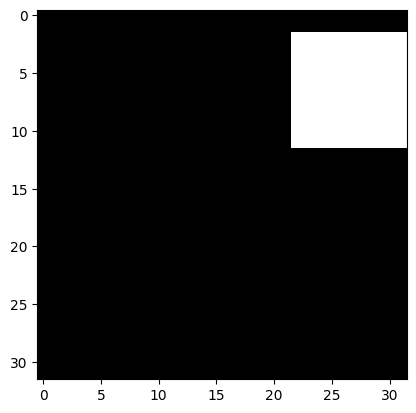

In [9]:
plt.imshow(mask, cmap='gray')

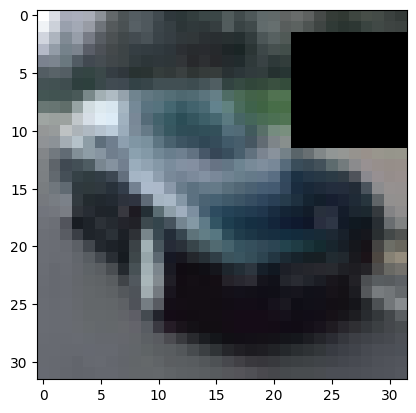

In [10]:
imshow((1 - mask) * train[1000][0])

# GAN

## Define Generator

In [11]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

class Unflatten(nn.Module):

    def __init__(self, shape):
        super(Unflatten, self).__init__()
        self.shape = shape

    def forward(self, X):
        return X.view(-1, *self.shape)

class Generator(nn.Module):

    def __init__(self, im_channels):
        super(Generator, self).__init__()


        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),


            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, 3, stride=1, padding=2, dilation=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=4, dilation=4),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=8, dilation=8),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=16, dilation=16),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),

            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, im_channels, 3, stride=1, padding=1)

        )

    def forward(self, X):
        out = self.net(X)
        return out


## Define Discriminator

### Local Discriminator

In [12]:
class LocalDiscriminator(nn.Module):
    def __init__(self, im_channels, region_size=16):
        super(LocalDiscriminator, self).__init__()

        self.region_size = region_size

        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024)
        )

    def forward(self, X, mask_bounds):

        local_regions = self._get_local_regions(X, mask_bounds)
        out = self.net(local_regions)

        return out

    def _get_local_regions(self, X, mask_bounds):

        N, ch, im_h, im_w = X.shape
        local_regions = torch.zeros((N, ch, self.region_size, self.region_size)).cuda()

        for i, bounds in enumerate(mask_bounds):
            y1, y2, x1, x2 = bounds

            ym, xm = (y1 + y2) // 2, (x1 + x2) // 2
            y1, x1 = ym - self.region_size // 2, xm - self.region_size // 2
            y2, x2 = y1 + self.region_size, x1 + self.region_size

            if y1 < 0:
                y1, y2 = 0, self.region_size
            elif y2 > im_h:
                y1, y2 = im_h - self.region_size, im_h

            if x1 < 0:
                x1, x2 = 0, self.region_size
            elif x2 > im_w:
                x1, x2 = im_w - self.region_size, im_w

            local_regions[i, :, :, :] = X[i, :, y1 : y2, x1 : x2]

        return local_regions

### Global Discriminator

In [13]:

class GlobalDiscriminator(nn.Module):
    def __init__(self, im_channels):
        super(GlobalDiscriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024)
        )

    def forward(self, X):
        out = self.net(X)
        return out


### Complete Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, local_d, global_d):
        super(Discriminator, self).__init__()
        self.local_discriminator = local_d
        self.global_discriminator = global_d
        self.fc = nn.Linear(2048, 1)

    def forward(self, X, mask_bounds):
        local_ = self.local_discriminator(X, mask_bounds)
        global_ = self.global_discriminator(X)
        concated = torch.cat((local_, global_), dim=1)
        out = self.fc(concated)

        return out


# Training GAN

In [15]:
g_loss_all, d_loss_all = [], []
train_loss_all, val_loss_all = [], []
# train_mae_all, val_mae_all = [], []
# train_dice_all, val_dice_all = [], []

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def train_gan(g, d, train, val, g_o, d_o, params, masks_fn):

    train_loader = data.DataLoader(train, batch_size=params['batch_size'], num_workers=0, pin_memory=True)
    val_loader = data.DataLoader(val, params['val_batch_size'], shuffle=True, pin_memory=True)
    val_loader = iter(cycle(val_loader))

    optimizer_g = g_o
    optimizer_d = d_o

    T_c, T_d = params['T_c'], params['T_d']
    w = params['w']
    for epoch in range(params['epochs']):
        ep_loss_g = 0.
        ep_loss_d = 0.
        fake_err = 0.
        real_err = 0.

        if epoch < T_c and epoch == 0:
                print(f'\n>>>> Training generator for {T_c} epochs.')

        if epoch < T_c + T_d and epoch == T_c:
                print(f'\n>>>> Training discriminator for {T_d} epochs.')

        if epoch == T_c + T_d:
                print(f'\n>>>> Training both generator and discriminator jointly.')

        start_time = time.time()

        g.train()
        d.train()
        for batch, _ in train_loader:

            N = batch.shape[0]
            batch = batch.cuda()

            masks_g, bounds_g = masks_fn(N)
            batch_masked = batch.clone() * (1 - masks_g)
            batch_with_masks = torch.cat((batch_masked, masks_g[:, :1]), dim=1)

            fake = g(batch_with_masks)

            loss_mse = (((batch - fake) * masks_g)**2).sum() / masks_g.sum()
            
#             loss_mae = (torch.abs(batch - fake) * masks_g).sum() / masks_g.sum()
            
#             intersection = ((batch * fake) * masks_g).sum()
#             union = (batch * masks_g).sum() + (fake * masks_g).sum()
#             epsilon = 1e-7  # Small constant to avoid division by zero
#             dice_coef = (2.0 * intersection + epsilon) / (union + epsilon)
            
#             train_loss_all.append(loss_mse)
#             train_mae_all.append(loss_mae)
#             train_dice_all.append(dice_coef)

            if epoch < T_c:
                loss_g = loss_mse
                loss_g.backward()
                optimizer_g.step()
                optimizer_g.zero_grad()
                ep_loss_g += loss_g.detach().cpu()
                continue
            else:
                inpainted = batch.clone()
                masks_byte = masks_g.byte()
                inpainted[masks_byte] = fake.detach()[masks_byte].view(-1)
                inpainted = torch.cat((inpainted, masks_g[:, :1]), dim=1)
                d_fake = d(inpainted.detach(), bounds_g)

                masks_d, bounds_d = masks_fn(N)
                real = torch.cat((batch.clone(), masks_d[:, :1]), dim=1)
                d_real = d(real, bounds_d)

                loss_d_fake = (d_fake**2).mean()
                loss_d_real = ((d_real - 1)**2).mean()
                loss_d = (loss_d_fake + loss_d_real) / 2
                loss_d.backward()
                optimizer_d.step()
                optimizer_d.zero_grad()

                if epoch >= T_c + T_d:
                    inpainted = batch.clone()
                    inpainted[masks_byte] = fake[masks_byte].view(-1)
                    inpainted = torch.cat((inpainted, masks_g[:, :1]), dim=1)
                    d_fake = d(inpainted, bounds_g)
                    loss_g = loss_mse + w * ((d_fake - 1)**2).mean()

                    loss_g.backward()
                    optimizer_g.step()
                    optimizer_g.zero_grad()

                    ep_loss_g += loss_g.detach().cpu()

                ep_loss_d += loss_d.detach().cpu()
                fake_err += loss_d_fake.detach().cpu()
                real_err += loss_d_real.detach().cpu()
#             break

        if not T_c <= epoch < T_c + T_d:
            g.eval()
            val_batch = next(val_loader)[0].cuda()
            N, ch, _, _ = val_batch.shape

            masks, _ = masks_fn(N)
            val_batch_masked = val_batch * (1 - masks)
            val_batch_masked = torch.cat((val_batch_masked, masks[:, :1]), dim=1)
            val_pred = g(val_batch_masked).detach()
            val_loss = (((val_batch - val_pred) * masks)**2).sum() / masks.sum()
            
#             val_loss_mae = (torch.abs(val_batch - val_pred) * masks).sum() / masks.sum()
            
#             val_intersection = ((val_batch * val_pred) * masks).sum()
#             val_union = (val_batch * masks).sum() + (val_pred * masks).sum()
#             epsilon = 1e-7  # Small constant to avoid division by zero
#             val_dice_coef = (2.0 * val_intersection + epsilon) / (val_union + epsilon)
            
            inpainted = val_batch.clone()
            masks_byte = masks.byte()
            inpainted[masks_byte] = val_pred[masks_byte]
            imgs = [
                val_batch[0].cpu(),
                masks[0].cpu(),
                val_batch_masked[:, :-1][0].cpu(),
                val_pred[0].cpu().clamp(0, 1),
                inpainted[0].cpu()
            ]
            imshow(torch.cat(imgs, dim=2))
            plt.axis('off')
            plt.show()

        g_loss_all.append(ep_loss_g)
        d_loss_all.append(ep_loss_d)
        val_loss_all.append(val_loss)
        
        print('epoch: %d, g_loss: %0.4f, val_loss: %0.4f, d_loss: %0.4f, fake_err: %0.4f, real_err: %0.4f, time: %0.2f' %\
              (epoch, ep_loss_g, val_loss, ep_loss_d, fake_err, real_err, time.time() - start_time))

In [16]:
global_d = GlobalDiscriminator(im_channels=3).cuda()
local_d = LocalDiscriminator(im_channels=3, region_size=16).cuda()
discriminator = Discriminator(local_d=local_d, global_d=global_d).cuda()

generator = Generator(im_channels=3).cuda()



>>>> Training both generator and discriminator jointly.


/tmp/ipykernel_778/940491495.py:75: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  inpainted[masks_byte] = fake.detach()[masks_byte].view(-1)
/tmp/ipykernel_778/940491495.py:92: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  inpainted[masks_byte] = fake[masks_byte].view(-1)
/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/tmp/ipykernel_778/940491495.py:128: UserWarning: indexing with dty

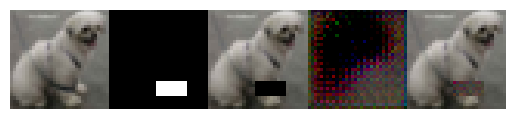

epoch: 0, g_loss: 5.2752, val_loss: 0.0824, d_loss: 32.0877, fake_err: 6.9329, real_err: 57.2426, time: 146.25


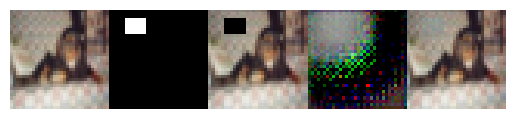

epoch: 1, g_loss: 1.7221, val_loss: 0.0311, d_loss: 27.7732, fake_err: 3.1362, real_err: 52.4102, time: 144.19


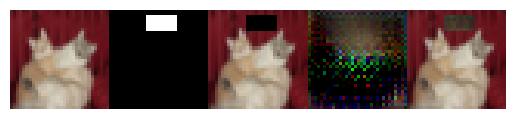

epoch: 2, g_loss: 1.4577, val_loss: 0.0271, d_loss: 26.2591, fake_err: 2.1516, real_err: 50.3665, time: 144.45


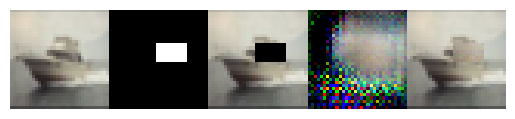

epoch: 3, g_loss: 1.2779, val_loss: 0.0250, d_loss: 25.2291, fake_err: 1.6802, real_err: 48.7780, time: 144.50


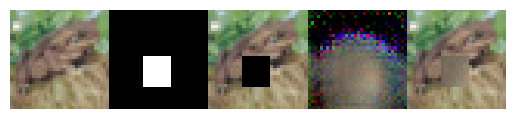

epoch: 4, g_loss: 1.2022, val_loss: 0.0229, d_loss: 24.3784, fake_err: 1.3751, real_err: 47.3818, time: 144.30


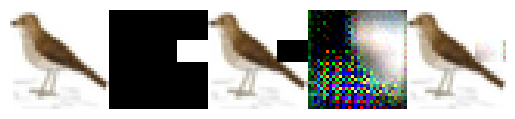

epoch: 5, g_loss: 1.1408, val_loss: 0.0226, d_loss: 23.6313, fake_err: 1.1920, real_err: 46.0707, time: 144.36


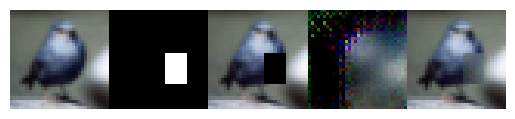

epoch: 6, g_loss: 1.1026, val_loss: 0.0220, d_loss: 22.9761, fake_err: 1.0887, real_err: 44.8635, time: 144.32


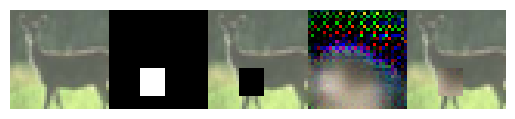

epoch: 7, g_loss: 1.0703, val_loss: 0.0206, d_loss: 22.3631, fake_err: 1.0335, real_err: 43.6927, time: 144.47


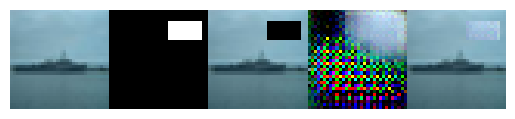

epoch: 8, g_loss: 1.0511, val_loss: 0.0228, d_loss: 21.7753, fake_err: 1.0148, real_err: 42.5358, time: 144.44


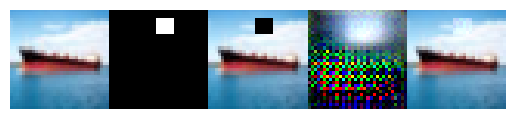

epoch: 9, g_loss: 1.0359, val_loss: 0.0225, d_loss: 21.2301, fake_err: 1.0501, real_err: 41.4101, time: 144.36


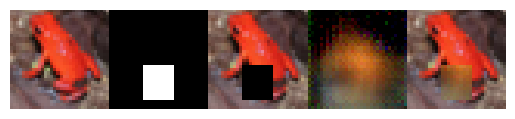

epoch: 10, g_loss: 1.0043, val_loss: 0.0193, d_loss: 20.6919, fake_err: 1.0952, real_err: 40.2887, time: 144.41


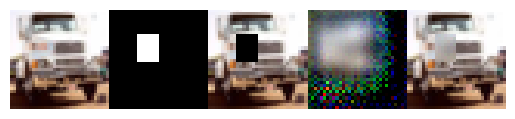

epoch: 11, g_loss: 0.9756, val_loss: 0.0177, d_loss: 20.1767, fake_err: 1.1826, real_err: 39.1707, time: 144.62


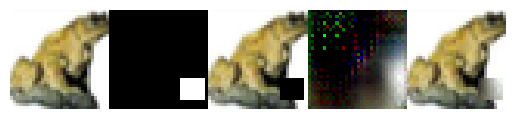

epoch: 12, g_loss: 0.9586, val_loss: 0.0191, d_loss: 19.6696, fake_err: 1.2980, real_err: 38.0412, time: 144.50


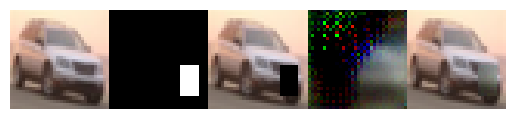

epoch: 13, g_loss: 0.9480, val_loss: 0.0205, d_loss: 19.1761, fake_err: 1.4389, real_err: 36.9133, time: 144.35


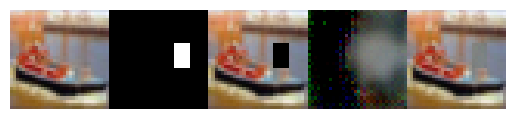

epoch: 14, g_loss: 0.9605, val_loss: 0.0192, d_loss: 18.6864, fake_err: 1.6035, real_err: 35.7694, time: 144.40


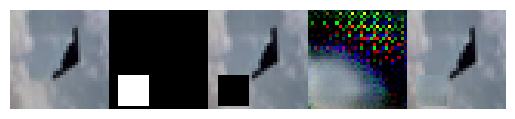

epoch: 15, g_loss: 0.9311, val_loss: 0.0184, d_loss: 18.2157, fake_err: 1.8009, real_err: 34.6306, time: 144.33


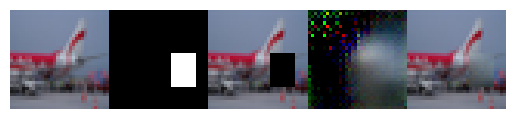

epoch: 16, g_loss: 0.9165, val_loss: 0.0172, d_loss: 17.7541, fake_err: 2.0246, real_err: 33.4836, time: 144.32


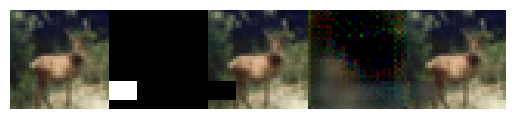

epoch: 17, g_loss: 0.9262, val_loss: 0.0177, d_loss: 17.3021, fake_err: 2.2634, real_err: 32.3407, time: 144.38


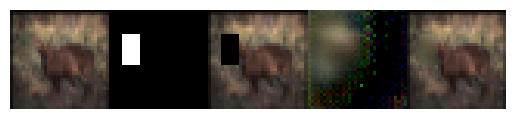

epoch: 18, g_loss: 0.9048, val_loss: 0.0173, d_loss: 16.8702, fake_err: 2.5408, real_err: 31.1995, time: 144.15


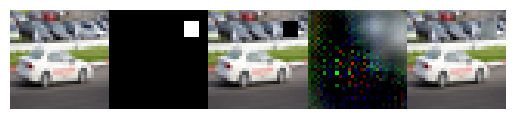

epoch: 19, g_loss: 0.8917, val_loss: 0.0171, d_loss: 16.4567, fake_err: 2.8420, real_err: 30.0713, time: 144.31


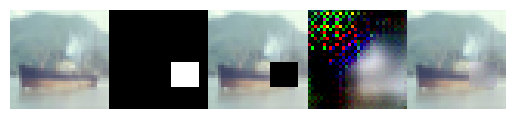

epoch: 20, g_loss: 0.8771, val_loss: 0.0177, d_loss: 16.0698, fake_err: 3.1782, real_err: 28.9614, time: 144.23


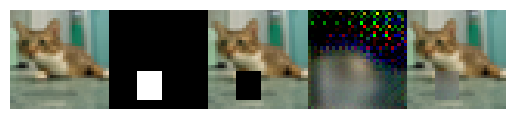

epoch: 21, g_loss: 0.8715, val_loss: 0.0179, d_loss: 15.6858, fake_err: 3.5159, real_err: 27.8558, time: 144.34


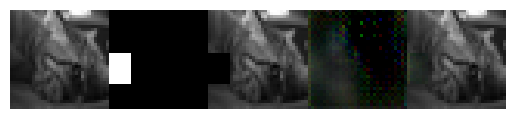

epoch: 22, g_loss: 0.8716, val_loss: 0.0177, d_loss: 15.3321, fake_err: 3.8836, real_err: 26.7807, time: 144.48


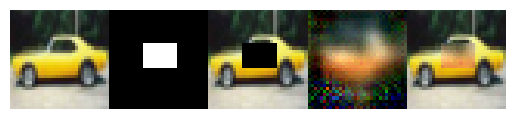

epoch: 23, g_loss: 0.8614, val_loss: 0.0168, d_loss: 15.0064, fake_err: 4.2780, real_err: 25.7347, time: 144.62


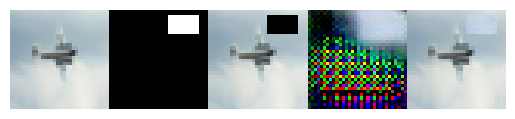

epoch: 24, g_loss: 0.8660, val_loss: 0.0196, d_loss: 14.7047, fake_err: 4.6854, real_err: 24.7241, time: 144.40


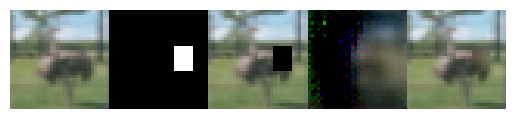

epoch: 25, g_loss: 0.8520, val_loss: 0.0179, d_loss: 14.4240, fake_err: 5.1017, real_err: 23.7463, time: 144.41


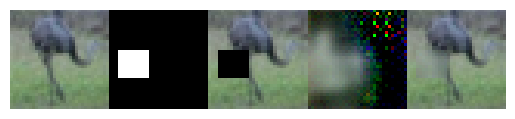

epoch: 26, g_loss: 0.8540, val_loss: 0.0201, d_loss: 14.1721, fake_err: 5.5322, real_err: 22.8120, time: 144.52


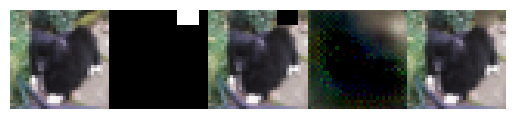

epoch: 27, g_loss: 0.8414, val_loss: 0.0168, d_loss: 13.9380, fake_err: 5.9604, real_err: 21.9156, time: 144.38


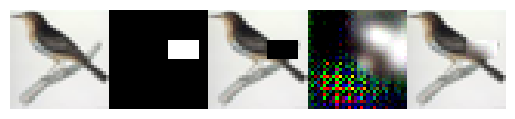

epoch: 28, g_loss: 0.8262, val_loss: 0.0182, d_loss: 13.7330, fake_err: 6.3976, real_err: 21.0685, time: 144.62


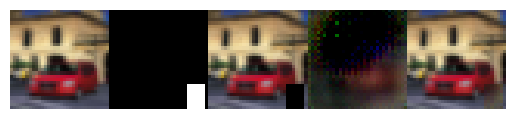

epoch: 29, g_loss: 0.8338, val_loss: 0.0157, d_loss: 13.5558, fake_err: 6.8411, real_err: 20.2706, time: 144.45
Training time: 4333.893573284149 seconds


In [17]:
train_params = {}
train_params['w'] = 0.0005
train_params['learning_rate_g'] = 0.0001
train_params['learning_rate_d'] = 0.00001
train_params['batch_size'] = 800
train_params['val_batch_size'] = 1024
train_params['T_c'] = 0
train_params['T_d'] = 0
train_params['epochs'] = 30 + train_params['T_c'] + train_params['T_d']

def gen_masks(N, ch=3):
    masks, bounds = create_hole_masks(N, 32, 32, (5, 12), (5, 12), same_size=False)
    return masks.repeat_interleave(ch, dim=1).cuda(), bounds

optimizer_g = optim.Adam(generator.parameters(), lr=train_params['learning_rate_g'])
optimizer_d = optim.Adam(discriminator.parameters(), lr=train_params['learning_rate_d'])

torch.cuda.empty_cache()

# Record the start time
start_time = time.time()

train_gan(generator, discriminator, train, val, optimizer_g, optimizer_d, train_params, gen_masks)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

## Visualize Progress

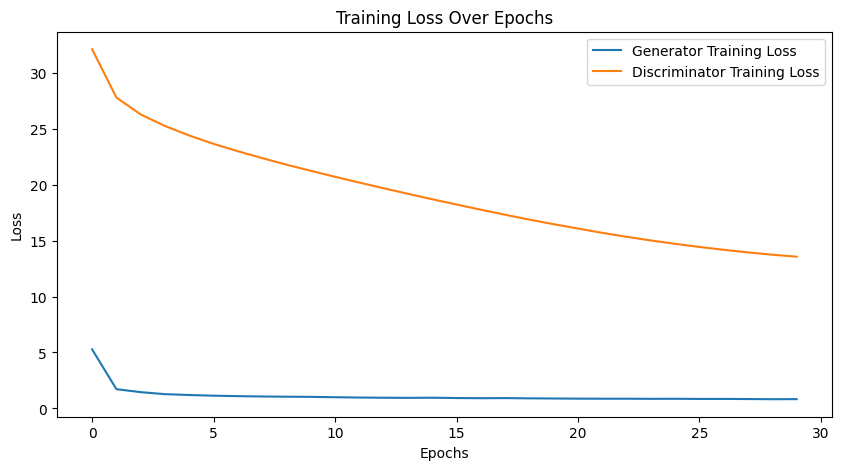

In [18]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(g_loss_all, label='Generator Training Loss')
plt.plot(d_loss_all, label='Discriminator Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

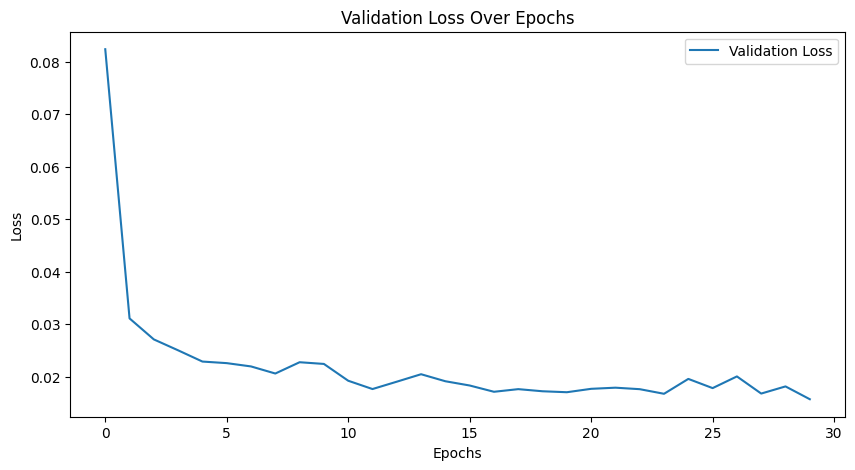

In [19]:
val_loss_all_cpu = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_loss_all]

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(val_loss_all_cpu, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluation

In [20]:
model = generator
model.eval()
N = 512
test_loader = iter(data.DataLoader(test, N, shuffle=True, pin_memory=False))

loss = 0
pixels = 0
loss_mse = 0
loss_mae = 0
intersection = 0.0
union = 0.0

for batch, _ in test_loader:
    masks, _ = gen_masks(batch.shape[0])
    batch_masked = batch.clone().cuda() * (1 - masks)
    batch_masked = torch.cat((batch_masked, masks[:, :1]), dim=1)
    pred = model(batch_masked).clamp(0, 1).detach()

    loss += (((batch.cuda() - pred) * masks)**2).sum().detach().cpu()
    pixels += masks.sum().detach().cpu()
    
    # Calculate MSE
    loss_mse += (((batch.cuda() - pred) * masks)**2).sum().item()  # Detach and convert to scalar
    # Calculate MAE
    loss_mae += (torch.abs(batch.cuda() - pred) * masks).sum().item()  # Detach and convert to scalar

    # Calculate Dice coefficient
    intersection += ((batch.cuda() * pred) * masks).sum().item()
    union += (batch.cuda() * masks).sum().item() + (pred * masks).sum().item()

loss_all = loss / pixels

# Calculate mean MSE and MAE
mean_loss_mse = loss_mse / pixels
mean_loss_mae = loss_mae / pixels

# Calculate Dice coefficient
epsilon = 1e-7  # Small constant to avoid division by zero
dice_coef = (2.0 * intersection + epsilon) / (union + epsilon)

# Print or use the results as needed
print("Loss:", loss_all)
print("Mean Squared Error (MSE):", mean_loss_mse)
print("Mean Absolute Error (MAE):", mean_loss_mae)
print("Dice Coefficient:", dice_coef)


Loss: tensor(0.0161)
Mean Squared Error (MSE): tensor(0.0161)
Mean Absolute Error (MAE): tensor(0.0906)
Dice Coefficient: 0.5637718994532561


/tmp/ipykernel_778/3554521084.py:3: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/IndexingUtils.h:27.)
  inpainted[masks_byte] = pred[masks_byte].view(-1)


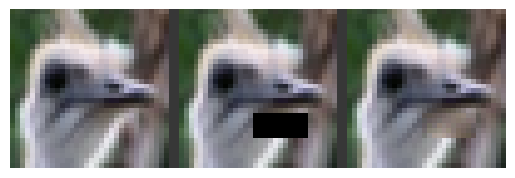

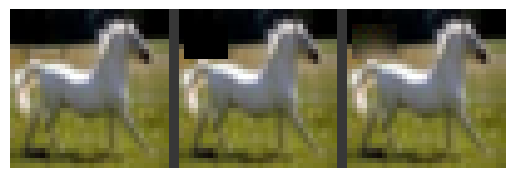

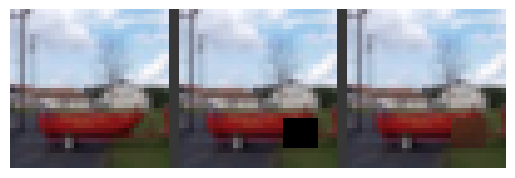

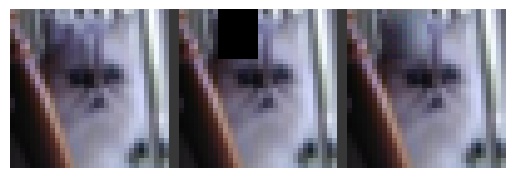

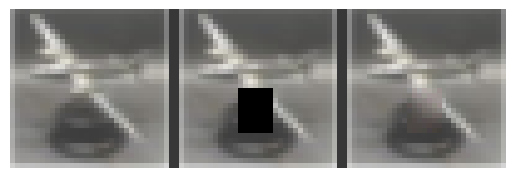

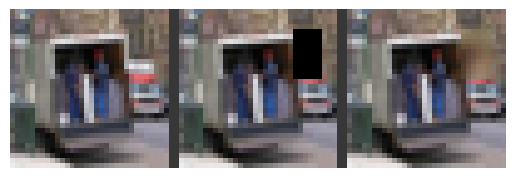

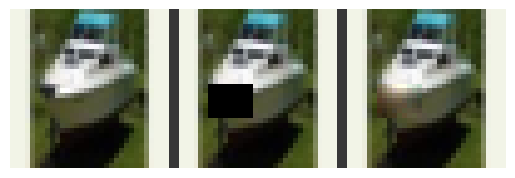

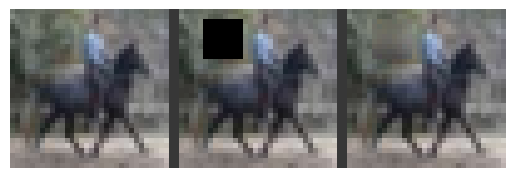

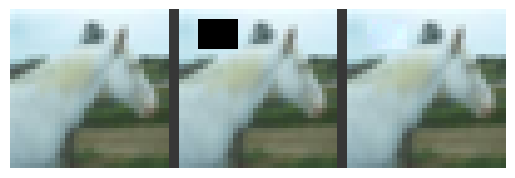

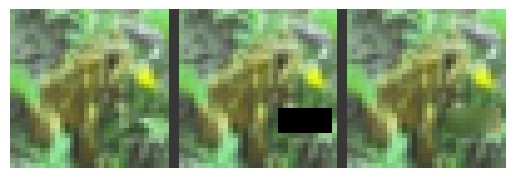

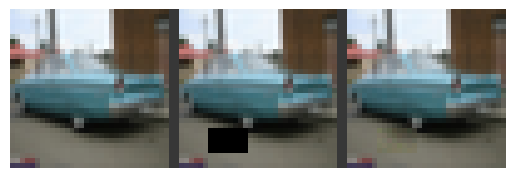

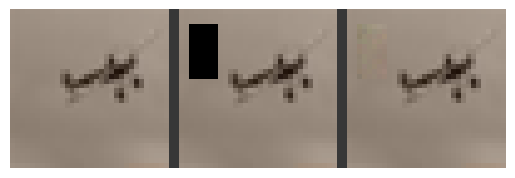

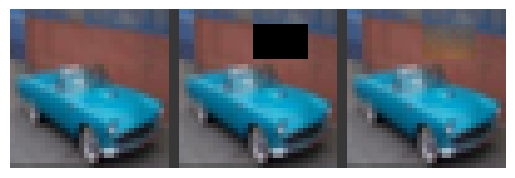

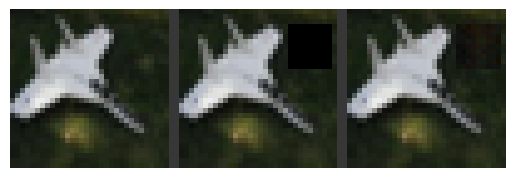

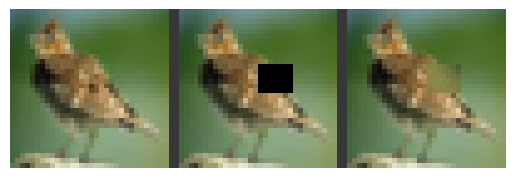

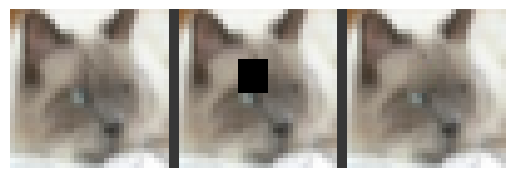

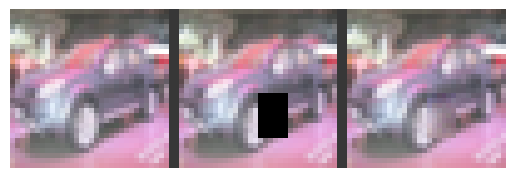

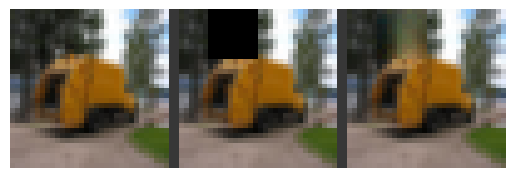

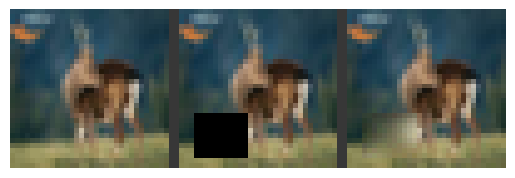

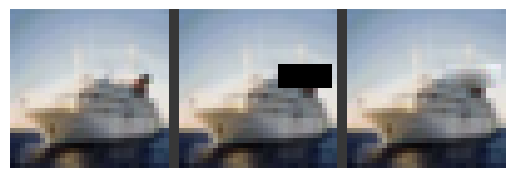

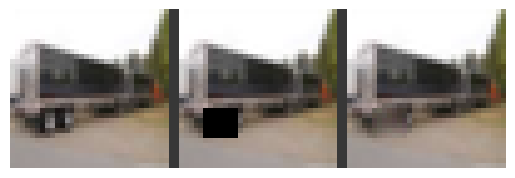

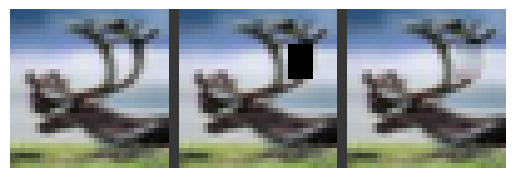

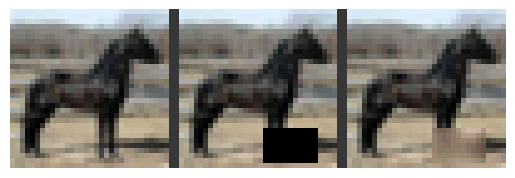

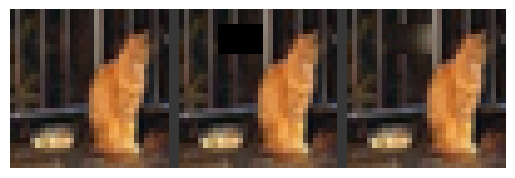

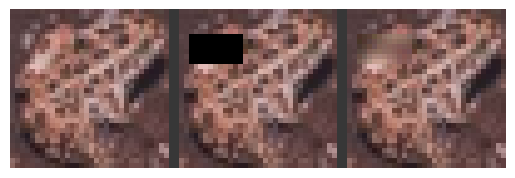

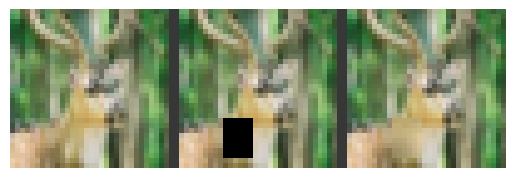

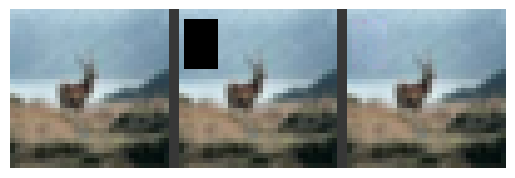

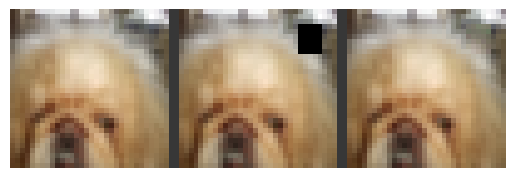

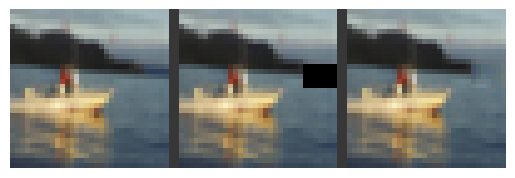

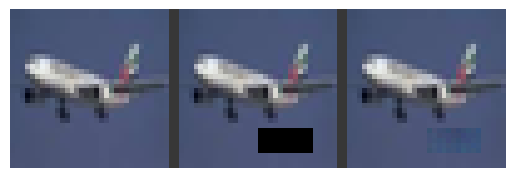

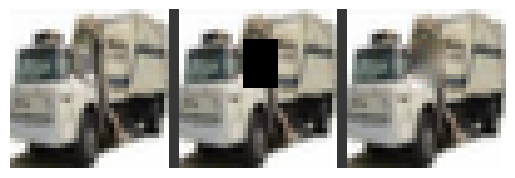

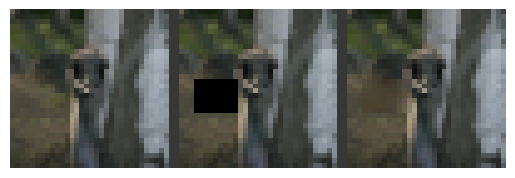

In [21]:
inpainted = batch.cuda().clone()
masks_byte = masks.byte()
inpainted[masks_byte] = pred[masks_byte].view(-1)
border = torch.zeros((3, 32, 2)) + 0.2196

for i in range(32):
    imgs = [
        batch[i].cpu(),
        border,
        batch_masked[:, :-1][i].cpu(),
#         pred[i].cpu(),
        border,
        inpainted[i].cpu()
    ]
    tmp = torch.cat(imgs, dim=2)
    imshow(tmp)
    plt.axis('off')
    plt.show()

# Save Model

In [22]:
model_save_name = 'generator.pt'
path = F"{model_save_name}"
torch.save(generator.state_dict(), path)

model_save_name = 'discriminator.pt'
path = F"{model_save_name}"
torch.save(discriminator.state_dict(), path)